In [1]:
# --- Instalall detectron2 ---

!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -U opencv-python tqdm pyyaml imageio scikit-image
!pip install git+https://github.com/facebookresearch/detectron2.git

Looking in indexes: https://download.pytorch.org/whl/cu118
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-jkh4vut6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-jkh4vut6
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.7 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=7084973 sha256=b9d49d66f57f12edb16c053c8eb4c4b7659cbddfa5199f4bdbcf6e73efd7f94d
  Stored in directory: /tmp/pip-

In [2]:
from google.colab import drive
drive.mount("/content/drive")

import os, glob

DATA_ROOT = "/content/drive/MyDrive"

TRAIN_IMAGES = f"{DATA_ROOT}/Original Images"
TRAIN_MASKS  = f"{DATA_ROOT}/Original Masks OTSU"
TEST_IMAGES  = f"{DATA_ROOT}/test_images"
TEST_MASKS   = f"{DATA_ROOT}/test_masks OTSU"

print("TRAIN_IMAGES:", TRAIN_IMAGES)
print("TRAIN_MASKS :", TRAIN_MASKS)
print("TEST_IMAGES :", TEST_IMAGES)
print("TEST_MASKS  :", TEST_MASKS)

def list_images_anyext(path):
    exts = ["*.tif", "*.tiff", "*.TIF", "*.TIFF", "*.png", "*.jpg", "*.jpeg"]
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(path, e)))
    return sorted(files)

print("Train Images:", len(list_images_anyext(TRAIN_IMAGES)))
print("Train Masks :", len(list_images_anyext(TRAIN_MASKS)))
print("Test  Images:", len(list_images_anyext(TEST_IMAGES)))
print("Test  Masks :", len(list_images_anyext(TEST_MASKS)))


Mounted at /content/drive
TRAIN_IMAGES: /content/drive/MyDrive/Original Images
TRAIN_MASKS : /content/drive/MyDrive/Original Masks OTSU
TEST_IMAGES : /content/drive/MyDrive/test_images
TEST_MASKS  : /content/drive/MyDrive/test_masks OTSU
Train Images: 18
Train Masks : 18
Test  Images: 4
Test  Masks : 4


In [34]:
import os, glob, re
import numpy as np
from PIL import Image
from skimage import measure
from detectron2.structures import BoxMode


from skimage import measure, morphology

def mask_to_polygons(mask, min_area=8):
    """
    Convierte una máscara binaria (HxW) en polígonos (Detectron2 format).
    """
    mask = morphology.remove_small_objects(mask.astype(bool), min_size=min_area)
    mask = mask.astype(np.uint8)

    contours = measure.find_contours(mask, 0.5)
    polygons = []

    for contour in contours:
        if len(contour) < 3:
            continue
        # (row, col) -> (x, y)
        poly = contour[:, ::-1].ravel().tolist()
        if len(poly) >= 6:
            polygons.append(poly)

    return polygons

def _norm_key_any(s):
    base = os.path.splitext(os.path.basename(s))[0].lower()
    # removing "mask" from names
    base = re.sub(r'(^|[.\- _])mask([.\- _]|$)', r'\1\2', base)
    base = re.sub(r'[.\- _]+', '_', base).strip('_')
    return base

def _list_any(path):
    exts = ["*.tif","*.tiff","*.TIF","*.TIFF","*.png","*.jpg","*.jpeg"]
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(path, e)))
    return sorted(files)

def get_data_dicts_from_tiff(image_dir, mask_dir, class_names):

    images = _list_any(image_dir)
    masks  = _list_any(mask_dir)

    img_map = {_norm_key_any(p): p for p in images}
    msk_map = {_norm_key_any(p): p for p in masks}

    common = sorted(set(img_map.keys()) & set(msk_map.keys()))

    dataset = []

    for k in common:
        ipath = img_map[k]
        mpath = msk_map[k]

        with Image.open(ipath) as im:
            w, h = im.size

        mask = np.array(Image.open(mpath))
        mask_bin = (mask > 0).astype("uint8")

        labeled = measure.label(mask_bin, connectivity=2)

        objs = []
        for lab in range(1, labeled.max() + 1):
            comp = (labeled == lab).astype("uint8")

            polys = mask_to_polygons(comp)
            if len(polys) == 0:
                continue

            ys, xs = np.where(comp > 0)
            x0, y0, x1, y1 = xs.min(), ys.min(), xs.max(), ys.max()

            objs.append({
                "bbox": [float(x0), float(y0), float(x1), float(y1)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": polys,
                "category_id": 0,
                "iscrowd": 0
            })

        dataset.append({
            "file_name": ipath,
            "image_id": k,
            "height": h,
            "width": w,
            "annotations": objs
        })

    return dataset


In [35]:
from detectron2.data import DatasetCatalog, MetadataCatalog

CLASSES = ["pore"]

def _loader_train():
    return get_data_dicts_from_tiff_bitmask(TRAIN_IMAGES, TRAIN_MASKS, CLASSES, verbose=False)

def _loader_test():
    return get_data_dicts_from_tiff_bitmask(TEST_IMAGES, TEST_MASKS, CLASSES, verbose=False)

DatasetCatalog.clear()
DatasetCatalog.register("category_train", _loader_train)
DatasetCatalog.register("category_test",  _loader_test)

MetadataCatalog.get("category_train").set(thing_classes=CLASSES)
MetadataCatalog.get("category_test").set(thing_classes=CLASSES)

print("category_train size:", len(_loader_train()))
print("category_test  size:", len(_loader_test()))

micro_metadata = MetadataCatalog.get("category_train")



category_train size: 18
category_test  size: 4


In [5]:
#Check there's no wrong boxes
data = _loader_train()
bad = []

for i, d in enumerate(data):
    H, W = d["height"], d["width"]
    for ann in d["annotations"]:
        x0, y0, x1, y1 = ann["bbox"]
        if not (0 <= x0 < x1 <= W and 0 <= y0 < y1 <= H):
            bad.append((i, d["file_name"], (x0, y0, x1, y1), (W, H)))

print("Total bad boxes:", len(bad))
if bad:
    bad[:5]


Total bad boxes: 0


In [36]:
#Mapper definitive
import copy
import numpy as np
from PIL import Image
import torch
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils

def normalize_tiff(img):
    img = img.astype(np.float32)
    lo, hi = np.percentile(img, (1, 99))
    img = np.clip((img - lo) / (hi - lo + 1e-6), 0, 1)
    return (img * 255).astype(np.uint8)

def read_tiff_rgb(path):
    arr = np.array(Image.open(path))

    if arr.ndim == 2:
        arr = normalize_tiff(arr)
        arr = np.stack([arr, arr, arr], axis=-1)
    else:
        if arr.dtype != np.uint8:
            g = normalize_tiff(arr.mean(axis=2))
            arr = np.stack([g, g, g], axis=-1)

    return arr.astype(np.uint8)

def grayscale_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)

    # 1) Read + normalize + convert to RGB
    image = read_tiff_rgb(dataset_dict["file_name"])  # uint8 HxWx3

    # 2) No augmentations for now
    aug_input = T.AugInput(image)
    transform = T.NoOpTransform()
    image = aug_input.image

    # 3) Convert to tensor (C,H,W)
    image_tensor = torch.as_tensor(
        np.ascontiguousarray(image.transpose(2, 0, 1)),
        dtype=torch.float32
    )

    # 4) Transform annotations
    annos = [
        utils.transform_instance_annotations(obj, transform, image.shape[:2])
        for obj in dataset_dict["annotations"]
    ]

    instances = utils.annotations_to_instances(
        annos, image.shape[:2], mask_format="bitmask"
    )

    dataset_dict["image"] = image_tensor
    dataset_dict["instances"] = instances
    return dataset_dict


In [37]:
import copy
import torch
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils

def grayscale_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)

    # 1) imagen normalizada y en 3 canales
    image = _read_tiff_as_hwc_uint8(dataset_dict["file_name"])  # HxWx3 uint8

    aug_input = T.AugInput(image)
    transform = T.NoOpTransform()
    image = aug_input.image

    image_tensor = torch.as_tensor(
        np.ascontiguousarray(image.transpose(2, 0, 1)),
        dtype=torch.float32
    )

    # 2) anotaciones: usamos bitmask directamente
    annos = dataset_dict.get("annotations", [])

    instances = utils.annotations_to_instances(
        annos,
        image.shape[:2],
        mask_format="bitmask"
    )

    dataset_dict["image"] = image_tensor
    dataset_dict["instances"] = instances
    return dataset_dict


In [38]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_train_loader

class GrayTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=grayscale_mapper)


In [39]:
#Mask R-CNN config
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()

cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)

cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST  = ("category_test",)   # 👈 ahora sí hay val/test

cfg.DATALOADER.NUM_WORKERS = 2

# Input format for predictor when passing RGB arrays
cfg.INPUT.FORMAT = "RGB"
cfg.INPUT.MASK_FORMAT = "bitmask"

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # solo 'pore'

# Solver
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 1e-4
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = []
cfg.SOLVER.WARMUP_ITERS = 0

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64

cfg.OUTPUT_DIR = "./output_maskrcnn"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

print(cfg)


CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_SQRT: True
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('category_test',)
  TRAIN: ('category_train',)
FLOAT32_PRECISION: 
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: RGB
  MASK_FORMAT: bitmask
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FU

In [40]:
dl = GrayTrainer.build_train_loader(cfg)
batch = next(iter(dl))
print("Image shape:", batch[0]["image"].shape)   # expected: [3, H, W]
print("Instances:", batch[0]["instances"])


[12/04 14:55:13 d2.data.build]: Removed 0 images with no usable annotations. 18 images left.
[12/04 14:55:13 d2.data.build]: Using training sampler TrainingSampler
[12/04 14:55:13 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/04 14:55:13 d2.data.common]: Serializing 18 elements to byte tensors and concatenating them all ...
[12/04 14:55:14 d2.data.common]: Serialized dataset takes 432.08 MiB
[12/04 14:55:14 d2.data.build]: Making batched data loader with batch_size=1
Image shape: torch.Size([3, 768, 768])
Instances: Instances(num_instances=44, image_height=768, image_width=768, fields=[gt_boxes: Boxes(tensor([[  0.,   0.,   4.,   8.],
        [458.,  10., 505.,  53.],
        [730.,  22., 735.,  27.],
        [742.,  31., 743.,  33.],
        [299.,  36., 319.,  60.],
        [232.,  53., 275.,  96.],
        [398.,  75., 420., 101.],
        [540.,  79., 573., 115.],
        [438., 114., 481., 151.],
        [618., 127., 645.

TRAINING

In [41]:
trainer = GrayTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[12/04 14:55:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[12/04 14:55:21 d2.engine.train_loop]: Starting training from iteration 0
[12/04 14:55:27 d2.utils.events]:  eta: 0:02:01  iter: 19  total_loss: 3.062  loss_cls: 0.4771  loss_box_reg: 0.07724  loss_mask: 0.6712  loss_rpn_cls: 0.6735  loss_rpn_loc: 1.151    time: 0.2615  last_time: 0.3261  data_time: 0.1256  last_data_time: 0.1262   lr: 0.0001  max_mem: 1553M
[12/04 14:55:33 d2.utils.events]:  eta: 0:01:59  iter: 39  total_loss: 2.531  loss_cls: 0.2096  loss_box_reg: 0.02475  loss_mask: 0.585  loss_rpn_cls: 0.638  loss_rpn_loc: 1.075    time: 0.2686  last_time: 0.2514  data_time: 0.0897  last_data_time: 0.0869   lr: 0.0001  max_mem: 1553M
[12/04 14:55:38 d2.utils.events]:  eta: 0:01:52  iter: 59  total_loss: 2.275  loss_cls: 0.1291  loss_box_reg: 0.02441  loss_mask: 0.5822  loss_rpn_cls: 0.6224  loss_rpn_loc: 0.8725    time: 0.2638  last_time: 0.2501  data_time: 0.0860  last_data_time: 0.0837   lr: 0.0001  max_mem: 1553M
[12/04 14:55:44 d2.utils.events]:  eta: 0:01:49  iter: 79  total_l

Load trained model for inference

In [42]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog

import os

final_ckpt = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
print("Using checkpoint:", final_ckpt)
assert os.path.exists(final_ckpt), "model_final.pth not found in OUTPUT_DIR"

cfg.MODEL.WEIGHTS = final_ckpt
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # you can increase later (0.8, etc.)

predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get("category_train")


Using checkpoint: ./output_maskrcnn/model_final.pth
[12/04 14:58:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_maskrcnn/model_final.pth ...


In [43]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Path to Detectron2 metrics file
log_path = os.path.join(cfg.OUTPUT_DIR, "metrics.json")
print(f"Reading logs from: {log_path}")

records = []

with open(log_path, "r") as f:
    for line in f:
        try:
            rec = json.loads(line.strip())
        except json.JSONDecodeError:
            continue

        # Keep only entries that contain a loss value
        if "total_loss" in rec:
            records.append(rec)

print("Number of log entries read:", len(records))

# Convert to DataFrame
df = pd.DataFrame(records)

# Display the first rows
df.head()



Reading logs from: ./output_maskrcnn/metrics.json
Number of log entries read: 50


,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_mask,loss_rpn_cls,...,mask_rcnn/accuracy,mask_rcnn/false_negative,mask_rcnn/false_positive,rank_data_time,roi_head/num_bg_samples,roi_head/num_fg_samples,rpn/num_neg_anchors,rpn/num_pos_anchors,time,total_loss
0,0.073160,122.886297,0.750000,1.0000,0.0000,19,0.147005,0.570432,0.678785,0.685193,...,0.667052,0.0,1.0,0.073160,48.0,16.0,128.0,128.0,0.256013,3.352516
1,0.061097,108.795295,0.890625,0.4375,0.5625,39,0.018696,0.300637,0.596670,0.664965,...,0.710419,0.0,1.0,0.061097,48.0,16.0,128.0,128.0,0.227124,2.660031
2,0.080243,110.206386,0.953125,0.1875,0.8125,59,0.030239,0.155131,0.571957,0.635313,...,0.694794,0.0,1.0,0.080243,48.0,16.0,128.0,128.0,0.282650,2.239673
3,0.067999,101.750186,0.968750,0.1250,0.8750,79,0.035477,0.125471,0.557355,0.628783,...,0.705636,0.0,1.0,0.067999,48.0,16.0,128.0,128.0,0.232332,2.346347
4,0.071888,97.333775,0.968750,0.1250,0.8750,99,0.035931,0.115672,0.557834,0.624851,...,0.715003,0.0,1.0,0.071888,48.0,16.0,128.0,128.0,0.256002,2.288985


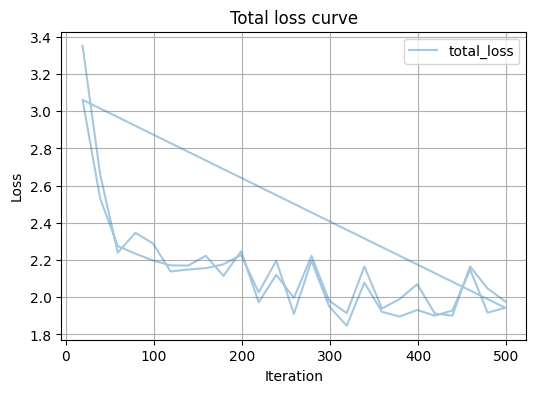

In [44]:
plt.figure(figsize=(6,4))
plt.plot(df["iteration"], df["total_loss"], label="total_loss", alpha=0.4)

window = 20
#plt.plot(df["iteration"], df["total_loss"].rolling(window).mean(),
         #label=f"total_loss (rolling {window})")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Total loss curve")
plt.legend()
plt.grid(True)
plt.show()


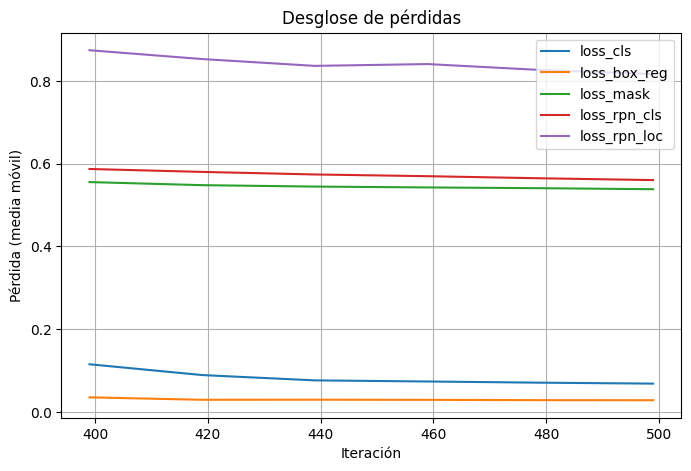

In [26]:
plt.figure(figsize=(8,5))

for key in ["loss_cls", "loss_box_reg", "loss_mask", "loss_rpn_cls", "loss_rpn_loc"]:
    if key in df.columns:
        plt.plot(df["iteration"], df[key].rolling(20).mean(), label=key)

plt.xlabel("Iteración")
plt.ylabel("Pérdida (media móvil)")
plt.title("Desglose de pérdidas")
plt.legend()
plt.grid(True)
plt.show()


# Visualize the predictions (masks and detections)

In [45]:
import torch
from detectron2.structures import Boxes
from detectron2.structures.boxes import pairwise_iou

def filter_instances_by_iou(instances, iou_thresh=0.8):
    """
    Remove boxes that overlap too much with higher-scored boxes.
    """
    if len(instances) == 0:
        return instances

    boxes = instances.pred_boxes.tensor.clone()
    scores = instances.scores.clone()

    order = torch.argsort(scores, descending=True)
    keep = []

    while len(order) > 0:
        i = order[0].item()
        keep.append(i)

        if len(order) == 1:
            break

        cur_box = boxes[i].unsqueeze(0)
        other_boxes = boxes[order[1:]]
        ious = pairwise_iou(Boxes(cur_box), Boxes(other_boxes)).squeeze(0)

        remaining = order[1:][ious <= iou_thresh]
        order = remaining

    keep = torch.tensor(keep, dtype=torch.long)
    return instances[keep]


Test image: /content/drive/MyDrive/Original Images/image_v2_03.tif


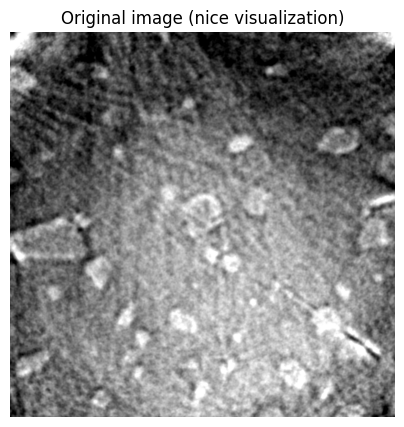

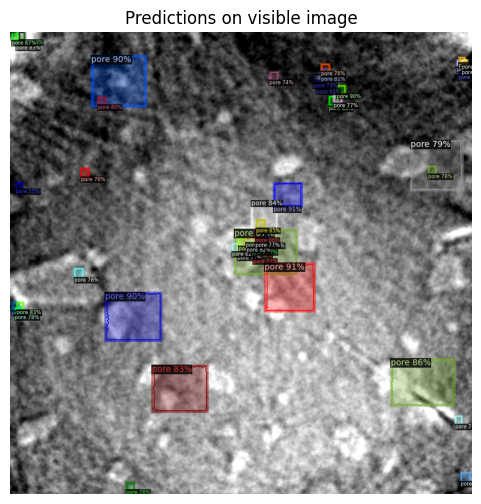

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# choose one image
test_img_path = list_images_anyext(TRAIN_IMAGES)[3]
print("Test image:", test_img_path)

# 1) load original image
img_original = np.array(Image.open(test_img_path))

# normalize for visualization (does not affect model input)
img_vis = img_original.astype(np.float32)
vmin, vmax = np.percentile(img_vis, (1, 99))
img_vis = np.clip((img_vis - vmin) / (vmax - vmin + 1e-6), 0, 1)

plt.figure(figsize=(5,5))
plt.imshow(img_vis, cmap="gray")
plt.title("Original image (nice visualization)")
plt.axis("off")
plt.show()

# 2) prepare input for model (RGB uint8)
if img_original.ndim == 2:
    img_input = np.stack([img_vis*255, img_vis*255, img_vis*255], axis=-1).astype(np.uint8)
else:
    img_input = img_original  # adapt if needed

# 3) prediction
outputs = predictor(img_input)
inst = outputs["instances"].to("cpu")

# optional: filter by IoU
inst = filter_instances_by_iou(inst, iou_thresh=0.2)

# 4) draw on top of grayscale image (converted to RGB)
img_vis_rgb = np.stack([img_vis*255]*3, axis=-1).astype(np.uint8)

v = Visualizer(
    img_vis_rgb,
    metadata=metadata,
    scale=1.0,
    instance_mode=ColorMode.IMAGE_BW,
)

result = v.draw_instance_predictions(inst)

plt.figure(figsize=(6,6))
plt.imshow(result.get_image())
plt.title("Predictions on visible image")
plt.axis("off")
plt.show()


Test image: /content/drive/MyDrive/Original Images/image_v2_03.tif
Nº instancias: 100


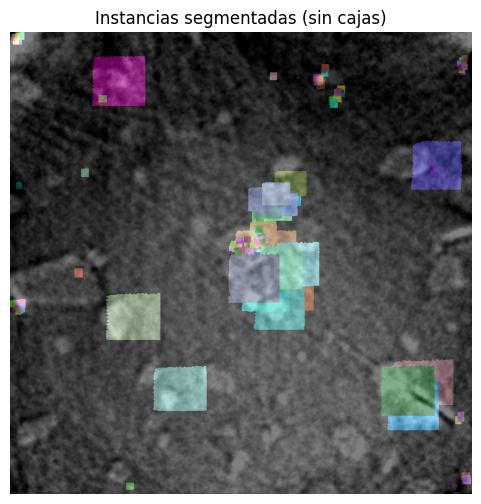

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

#  --- 1. Upload test image ---
test_img_path = list_images_anyext(TRAIN_IMAGES)[3]
print("Test image:", test_img_path)

img_original = np.array(Image.open(test_img_path))

#Normalization for visualization purposes only (does not affect the model)
img_vis = img_original.astype(np.float32)
vmin, vmax = np.percentile(img_vis, (1, 99))
img_vis = np.clip((img_vis - vmin) / (vmax - vmin + 1e-6), 0, 1)

# Input to the model in RGB uint8
if img_original.ndim == 2:
    img_input = np.stack([img_vis * 255]*3, axis=-1).astype(np.uint8)
else:
    img_input = img_original

# --- 2. Prediction ---
outputs = predictor(img_input)
inst = outputs["instances"].to("cpu")

print("Nº instancias:", len(inst))

if inst.has("pred_masks") and len(inst) > 0:
    masks = inst.pred_masks.numpy()   # (N, H, W)
    H, W = masks.shape[1:]

    # Color map per instance
    color_mask = np.zeros((H, W, 3), dtype=np.float32)
    rng = np.random.default_rng(0)  # semilla fija para colores consistentes

    for k in range(len(masks)):
        m = masks[k].astype(bool)
        color = rng.random(3)  # color RGB aleatorio en [0,1]
        color_mask[m] = color

    # --- 3. Visualize: gray background + colored masks ---
    plt.figure(figsize=(6,6))
    plt.imshow(img_vis, cmap="gray")
    plt.imshow(color_mask, alpha=0.5)  # solo máscaras, sin cajas
    plt.title("Segmented instances (without boxes)")
    plt.axis("off")
    plt.show()
else:
    print("The model has no pred_masks or has not detected any instances")


###See how are labeled the images the model is using for the training

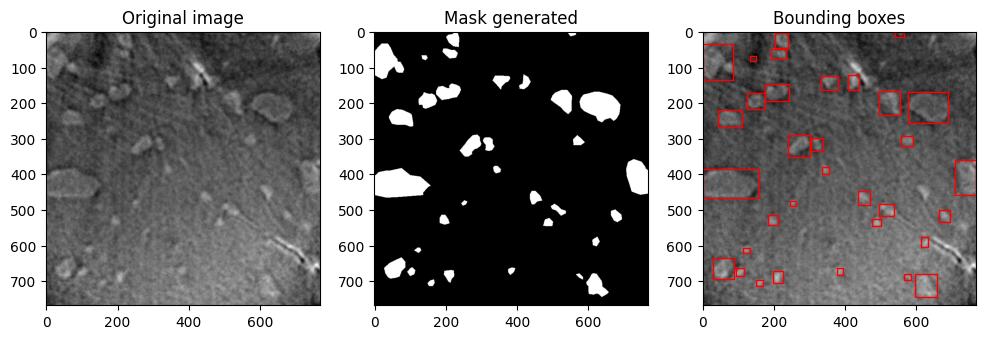

In [29]:
sample = DatasetCatalog.get("category_train")[0]

img = np.array(Image.open(sample["file_name"]))
mask = np.zeros(img.shape[:2], dtype=np.uint8)

for ann in sample["annotations"]:
    mask |= ann["segmentation"].astype(np.uint8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap="gray"); plt.title("Original image")
plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("Mask generated")
plt.subplot(1,3,3)
plt.imshow(img, cmap="gray");
for ann in sample["annotations"]:
    x0,y0,x1,y1 = ann["bbox"]
    rect = plt.Rectangle((x0,y0), x1-x0, y1-y0,
                         fill=False, edgecolor="red", linewidth=1)
    plt.gca().add_patch(rect)
plt.title("Bounding boxes")
plt.show()


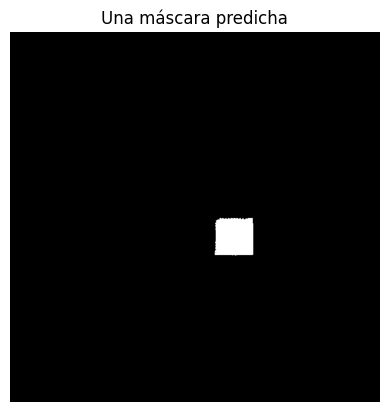

In [48]:
# The segmentation test depuration
inst = outputs["instances"].to("cpu")

if inst.has("pred_masks") and len(inst) > 0:
    m0 = inst.pred_masks[0].numpy()
    plt.imshow(m0, cmap="gray")
    plt.title("Una máscara predicha")
    plt.axis("off")
    plt.show()
